In [1]:
import pandas as pd
from textblob import TextBlob
import glob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
all_files = glob.glob("./dataset_cleaning/*.pkl")
all_files.sort()
datasets = []

for filename in all_files:
    print(filename)
    df = pd.read_pickle(filename)
    datasets.append(df)



./dataset_cleaning/dataset1Cleaned.pkl
./dataset_cleaning/dataset2Cleaned.pkl
./dataset_cleaning/dataset3Cleaned.pkl
./dataset_cleaning/dataset4Cleaned.pkl
./dataset_cleaning/dataset5Cleaned.pkl
./dataset_cleaning/dataset6Cleaned.pkl


In [3]:

def text_processing(tweet):
    
    tweet= tweet.lower()
    
    #Removing hyperlinks from the tweet
    tweet_no_links=re.sub(r'http\S+', '', tweet)
    
    #Generating the list of words in the tweet (hashtags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet_no_links)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word not in stopwords.words('english')]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return " ".join(normalized_tweet)
    
    
    return normalization(no_punc_tweet)

In [4]:
datasets[0].head()

,Informativeness,text
0,0,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...
1,0,Get in on the fun every Thursday with the @csi...
2,0,Welcome to our newest STUDENTathlete- Reagan B...
3,0,Denver Post: #Colorado governor signs bill cre...
4,0,Pretty sure I'm going to live in Manitou Sprin...


In [5]:
for i,ds in enumerate(datasets):
    print("Processing dataset {}".format(i+1))
    ds['text_processed']=ds['text'].apply(text_processing)

Processing dataset 1
Processing dataset 2
Processing dataset 3
Processing dataset 4
Processing dataset 5
Processing dataset 6


In [6]:
from sklearn.linear_model import SGDClassifier


text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier( penalty='l2', random_state=42))])

parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False),'clf-svm__alpha': (1e-5, 1e-3),
                  'clf-svm__loss':('hinge','log','perceptron'),'clf-svm__max_iter': (10, 100)}
gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm,scoring='roc_auc', n_jobs=-1, verbose=10)

In [26]:
results=[]
feature_importance=[]

for i,ds_train in enumerate(datasets):

    print("Training on Dataset {}".format(i+1))
    row=[]
    X_train = ds_train['text_processed'].values
    y_train = ds_train['Informativeness'].values
    
    gs_clf_svm = gs_clf_svm.fit(X_train, y_train)
    
    feature_names = gs_clf_svm.best_estimator_[0].get_feature_names() 
    coefs = gs_clf_svm.best_estimator_[-1].coef_[0]
    
    coefs_with_fns = sorted(zip(coefs, feature_names)) 
    df=pd.DataFrame(coefs_with_fns)
    df.columns='coefficient','word'
    df.sort_values(by='coefficient')
    feature_importance.append(df)
    
    for j,ds_test in enumerate(datasets):
        
        print("testing on Dataset {}".format(j+1))
        X_test = ds_test['text_processed'].values
        y_test = ds_test['Informativeness'].values
        
        row.append(gs_clf_svm.score(X_test, y_test))
    results.append(row)
    

Training on Dataset 1
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

testing on Dataset 1
testing on Dataset 2
testing on Dataset 3
testing on Dataset 4
testing on Dataset 5
testing on Dataset 6
Training on Dataset 2
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

testing on Dataset 1
testing on Dataset 2
testing on Dataset 3
testing on Dataset 4
testing on Dataset 5
testing on Dataset 6
Training on Dataset 3
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0830s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    8.8s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:

testing on Dataset 1
testing on Dataset 2
testing on Dataset 3
testing on Dataset 4
testing on Dataset 5
testing on Dataset 6
Training on Dataset 4
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

testing on Dataset 1
testing on Dataset 2
testing on Dataset 3
testing on Dataset 4
testing on Dataset 5
testing on Dataset 6
Training on Dataset 5
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0446s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1480s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    3.7s finished


testing on Dataset 1
testing on Dataset 2
testing on Dataset 3
testing on Dataset 4
testing on Dataset 5
testing on Dataset 6
Training on Dataset 6
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

testing on Dataset 1
testing on Dataset 2
testing on Dataset 3
testing on Dataset 4
testing on Dataset 5
testing on Dataset 6


In [27]:
df = pd.DataFrame(results)
df.columns= map( lambda x: x+1,df.columns)
df.index= map( lambda x: x+1,df.index)

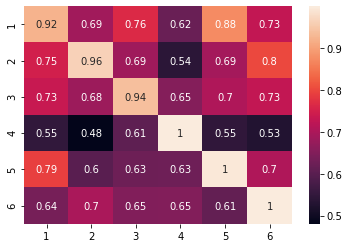

In [28]:
sns.heatmap(df, annot=True)


In [33]:
for feature_importance_dataset in feature_importance:
    print(feature_importance_dataset)

       coefficient           word
0        -2.649343           pray
1        -2.231199        prayers
2        -2.118380       thoughts
3        -2.038216  prayforboston
4        -1.904493  russianmeteor
...            ...            ...
18004     0.979222        suspect
18005     0.980826        typhoon
18006     1.171556          flood
18007     1.194530            psi
18008     1.237053       collapse

[18009 rows x 2 columns]
       coefficient         word
0        -6.371314         mora
1        -5.258818          hug
2        -4.820831        steve
3        -4.475976       reason
4        -4.267734         dear
...            ...          ...
18062     5.292642    magnitude
18063     5.557513      destroy
18064     5.638777    donations
18065     6.393180  devastation
18066     7.442023      cyclone

[18067 rows x 2 columns]
      coefficient              word
0       -2.519918            things
1       -2.328253          internet
2       -2.190676  prayforstockholm
3       -1.4